In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder

import nltk
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


import os, sys,re

In [146]:
df = pd.read_csv('../data/jobs_1.csv')
df.head()

,country,title,text
0,AT,Inform,https://www.linkedin.com/company/global-blue/l...
1,AT,Architect,https://www.linkedin.com/jobs/view/2589036509/...
2,AT,Manager,www.linkedin.com/jobs/view/2540581439/\n\nInfo...
3,AT,Analyst,https://www.linkedin.com/jobs/view/2997674064\...
4,AT,Engineer,https://www.linkedin.com/jobs/view/3020920801\...


In [147]:
df.shape

(269, 3)

In [148]:
# Removal of links
df['text'] = df['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))

# Extract Job Title from text
df['job_title'] = df['text'].apply(lambda x: (re.sub(r'^.*?\n', '\n', x).strip()).split('\n')[0] )

# Removal of punctuations
df['text'] = df['text'].str.replace('[^\w\s]','')

C:\Users\elsha\AppData\Local\Temp/ipykernel_16404/1940904911.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')


In [149]:
df

,country,title,text,job_title
0,AT,Inform,\n\nInformation Technology Security Manager\n\...,Information Technology Security Manager
1,AT,Architect,\n\nInformation Security Architect\n\nCopmany ...,Information Security Architect
2,AT,Manager,\n\nInformation Technology Security Manager\n\...,Information Technology Security Manager
3,AT,Analyst,\n\nThreat Detection Analyst\n\nCompany Radar ...,Threat Detection Analyst
4,AT,Engineer,\n\nIT Security Engineer\n\nCompany Global Blu...,IT Security Engineer
...,...,...,...,...
264,LV,IT Manager/Team lead,Compensa Vienna Insurance Group ADB Latvia is ...,Compensa Vienna Insurance Group ADB Latvia is ...
265,LV,IT HelpDesk L2 Engineer,Netcracker office in Riga is an integral compo...,Netcracker office in Riga is an integral compo...
266,LV,ONE IDENTITY- Software Sales Account Manager –...,Overview ONE IDENTITY Software Sales Account M...,Overview ONE IDENTITY- Software Sales Account ...
267,LV,System analyst,The opportunityAt Worldline our technology add...,"The opportunityAt Worldline, our technology ad..."


## Cluster the Text

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['text']

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 10000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [151]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,01,02,020,05,06204,0day,10,100,...,âshift,âthe,âthreat,ãledefrance,äeskã,ära,åadãme,åeåenã,å¾e,å¾ivot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Defining KMeans

In [152]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points

        Parameters
        -----------
        data: array or matrix, number_rows, number_features

        Returns
        -----------
        centroids: array, k, number_features
        """

        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])

        return self.centroids
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

In [153]:
data

0      \n\nInformation Technology Security Manager\n\...
1      \n\nInformation Security Architect\n\nCopmany ...
2      \n\nInformation Technology Security Manager\n\...
3      \n\nThreat Detection Analyst\n\nCompany Radar ...
4      \n\nIT Security Engineer\n\nCompany Global Blu...
                             ...                        
264    Compensa Vienna Insurance Group ADB Latvia is ...
265    Netcracker office in Riga is an integral compo...
266    Overview ONE IDENTITY Software Sales Account M...
267    The opportunityAt Worldline our technology add...
268    OpenStack while complex and challenging in man...
Name: text, Length: 269, dtype: object

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running
Wall time: 250 ms


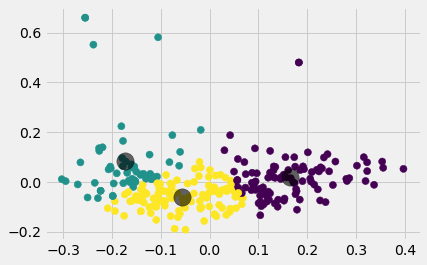

In [154]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
%time fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [155]:
con_df = pd.DataFrame(Y_sklearn) 
con_df['country'] = df['country']
con_df = con_df.rename( columns={0:'x', 1:'y' } )
con_df.head()

,x,y,country
0,0.043163,0.005600,AT
1,0.227280,0.058669,AT
2,0.166210,0.015037,AT
3,0.065742,-0.065485,AT
4,0.178885,-0.111479,AT


<AxesSubplot:xlabel='x', ylabel='y'>

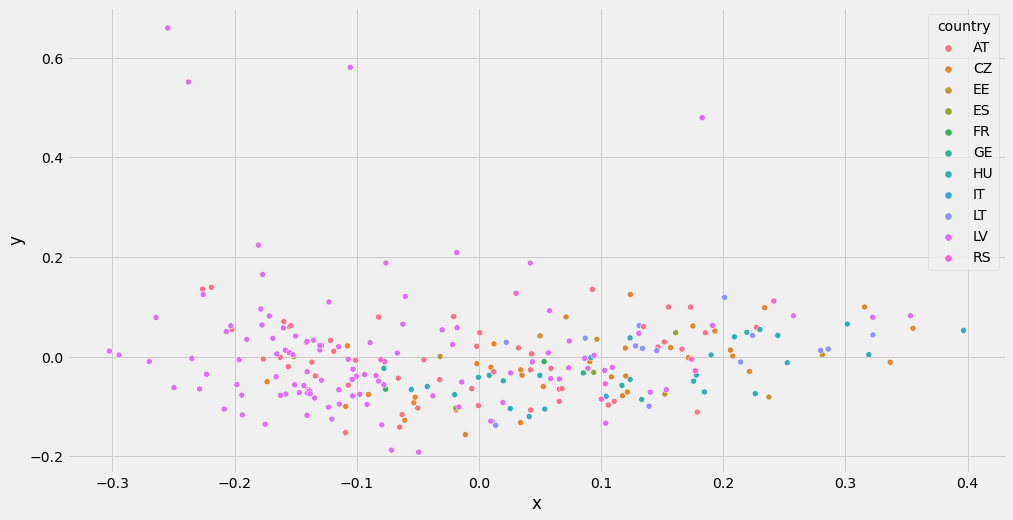

In [156]:
import seaborn as sns

plt.figure(figsize = (15,8))
sns.scatterplot(data=con_df, x='x', y='y', hue='country')

Wall time: 64 ms


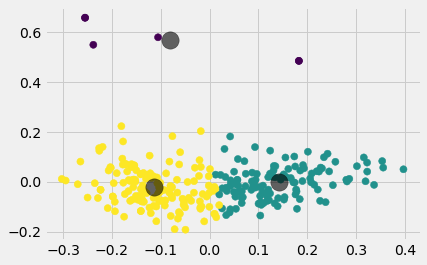

In [157]:
from sklearn.cluster import KMeans
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);
plt.savefig('../figures/kmeans3_text.png')

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


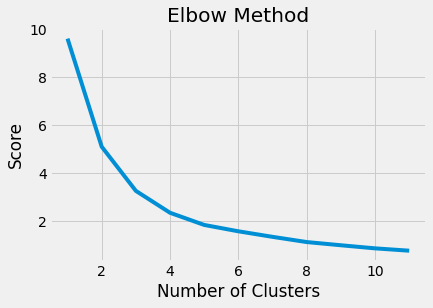

In [159]:
number_clusters = range(1, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 10) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.savefig('../figures/elbow_text.png')
plt.show()

Wall time: 74.1 ms


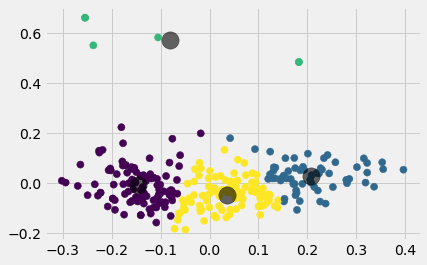

In [14]:
from sklearn.cluster import KMeans
n_clusters = 4
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

### Extracting the top Features

In [15]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
dfs[0]

,features,score
0,business,0.041718
1,product,0.039292
2,team,0.036037
3,data,0.035696
4,experience,0.035615
5,cloud,0.033347
6,work,0.031251
7,security,0.028968
8,sales,0.028678
9,technical,0.028472


<AxesSubplot:xlabel='score', ylabel='features'>

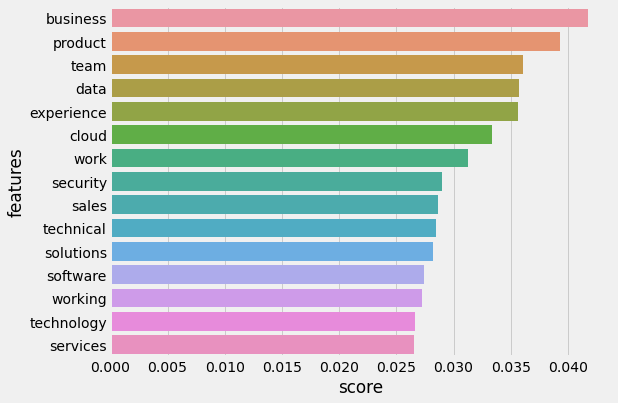

In [17]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

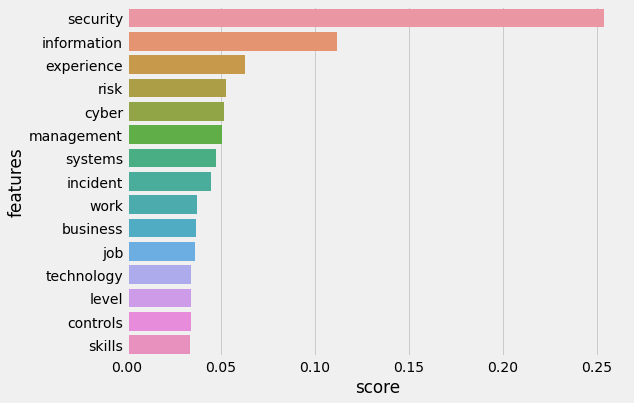

In [18]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

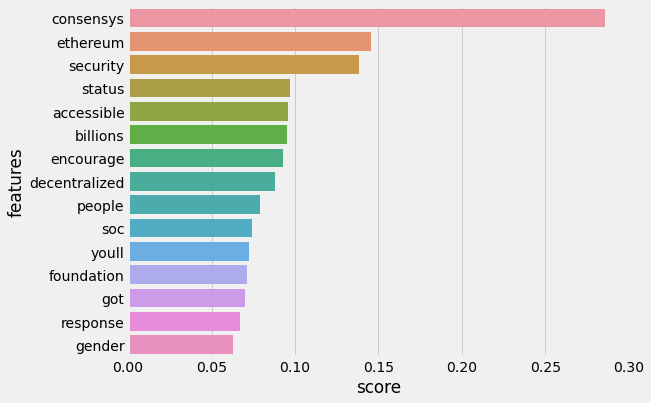

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

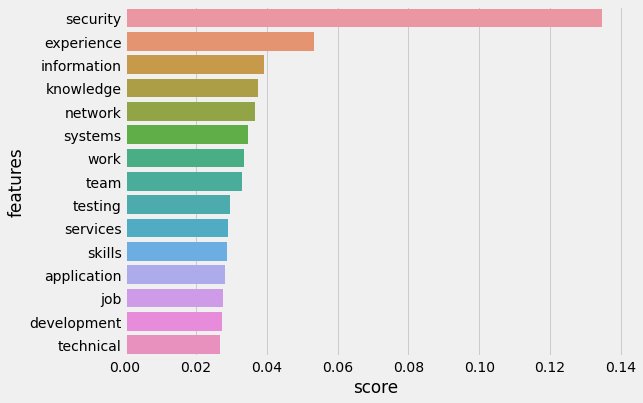

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])

In [21]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

C:\Users\elsha\AppData\Local\Temp/ipykernel_16404/2995603474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  yticks = ax.set_yticklabels(df.features)


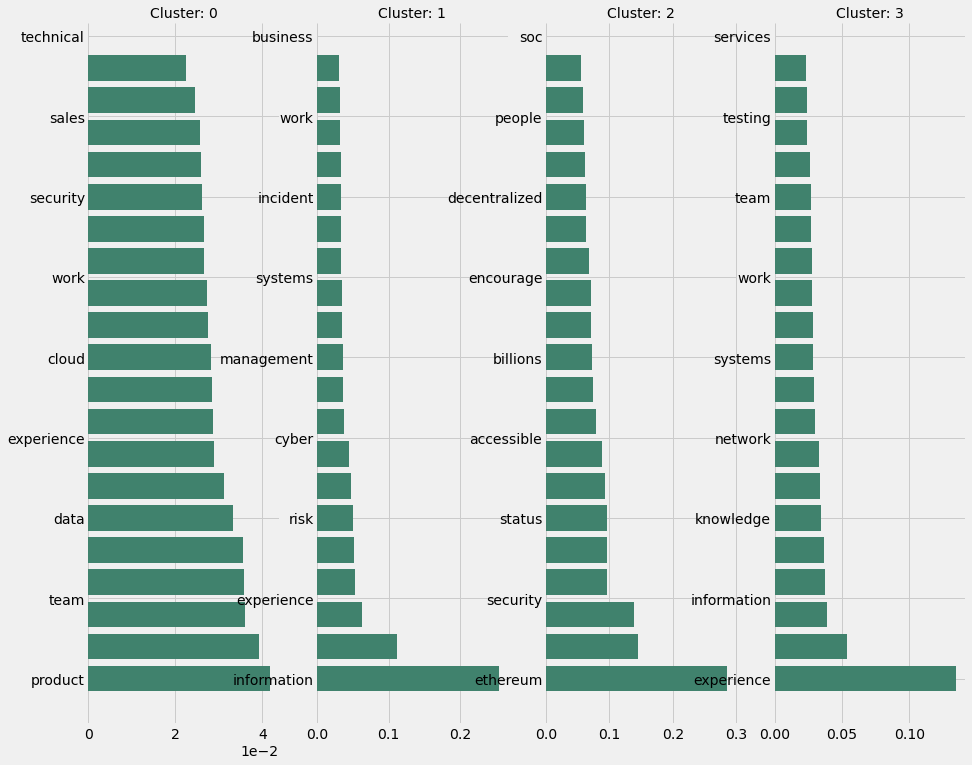

In [22]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


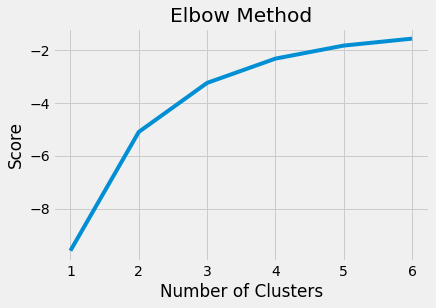

In [27]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Cluster the Job Title Names

In [28]:
df = pd.read_csv('../data/jobs_3.csv')
df.head()

,country,title,text,job_title
0,AT,Inform,Information Technology Security Manager Global...,Information Technology Security Manager
1,AT,Architect,Information Security Architect Copmany SWAROVS...,Information Security Architect
2,AT,Manager,Information Technology Security Manager Copman...,Information Technology Security Manager
3,AT,Analyst,Threat Detection Analyst Company Radar Cyber S...,Threat Detection Analyst
4,AT,Engineer,IT Security Engineer Company Global Blue Locat...,IT Security Engineer


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['job_title']

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 1000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [30]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,2k,accenture,access,account,accounts,acronis,active,administrator,advanced,advisor,...,vehicles,video,virtual,vodafone,white,wip,wireless,work,zentiva,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running
Wall time: 309 ms


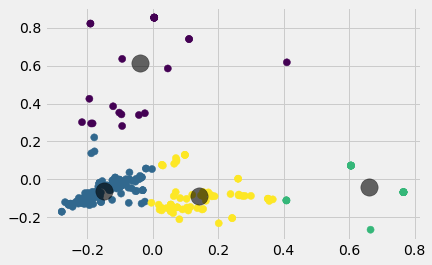

In [117]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(4, 1, 600)
%time fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


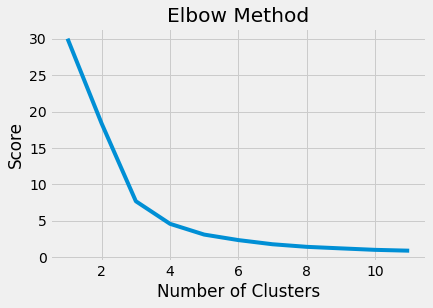

In [118]:
number_clusters = range(1, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 10) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [119]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, predicted_values, 20)

C:\Users\elsha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:xlabel='score', ylabel='features'>

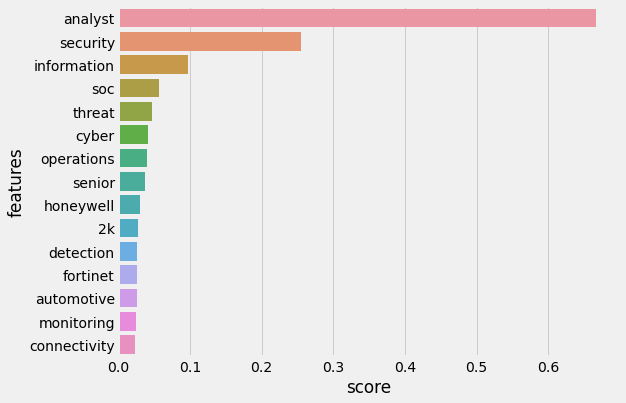

In [120]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

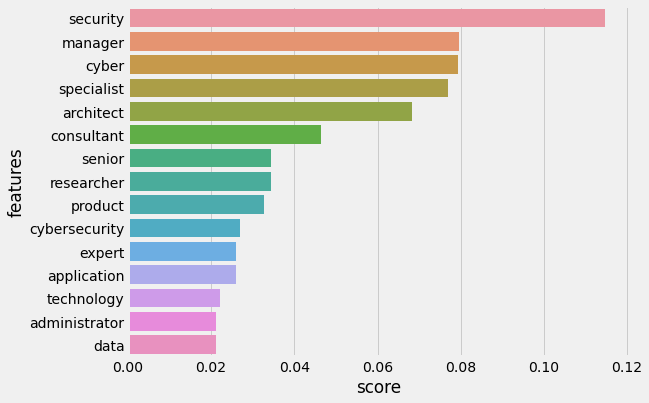

In [121]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

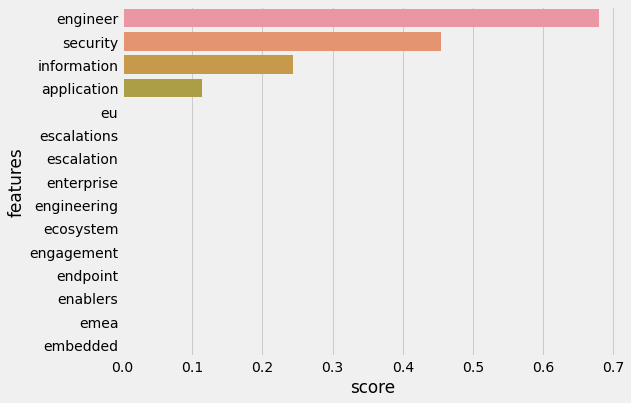

In [122]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [123]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

C:\Users\elsha\AppData\Local\Temp/ipykernel_16404/2995603474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  yticks = ax.set_yticklabels(df.features)


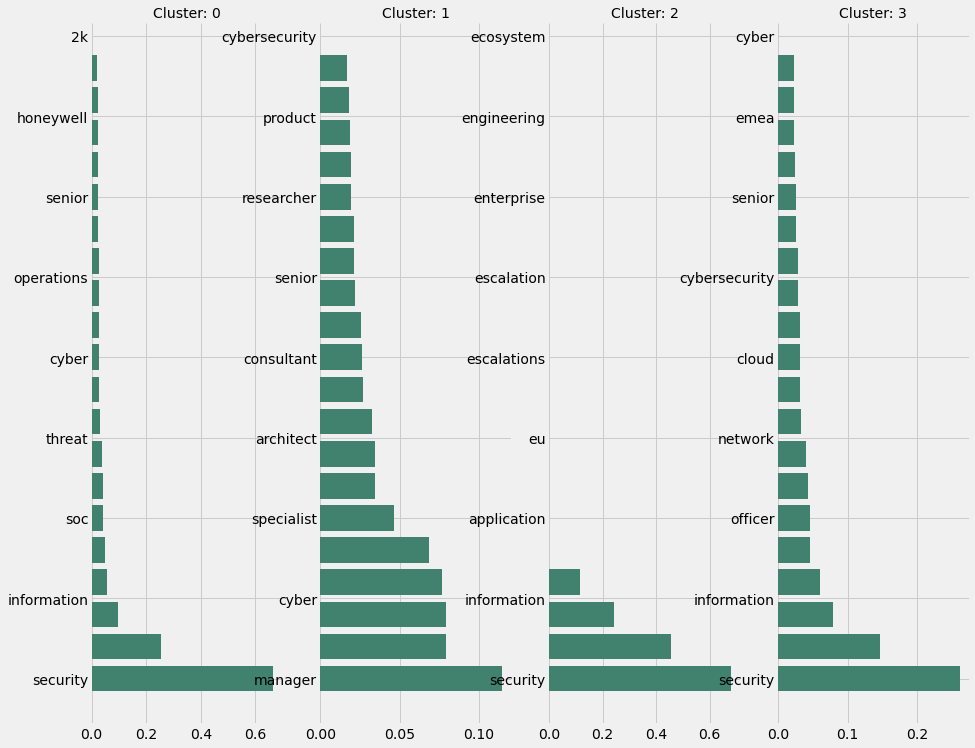

In [124]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)